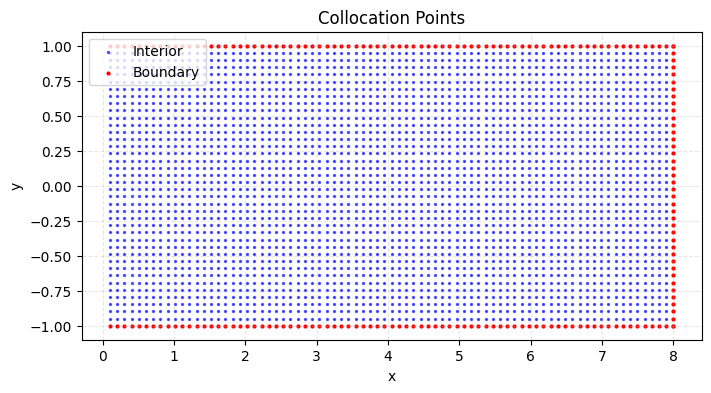

Initial energy: 28.488716215190053
Epoch [0/15000], Energy: 28.488716
Epoch [1000/15000], Energy: 4.116527
Epoch [2000/15000], Energy: 0.799013
Epoch [3000/15000], Energy: 0.299898
Epoch [4000/15000], Energy: 0.126114
Epoch [5000/15000], Energy: 0.047264
Epoch [6000/15000], Energy: -0.005814
Epoch [7000/15000], Energy: -0.047675
Epoch [8000/15000], Energy: -0.080965
Epoch [9000/15000], Energy: -0.107067
Epoch [10000/15000], Energy: -0.126507
Epoch [11000/15000], Energy: -0.140399
Epoch [12000/15000], Energy: -0.149850
Epoch [13000/15000], Energy: -0.155049
Epoch [14000/15000], Energy: -0.157240
Starting L-BFGS optimization...
Final energy: -0.16041578349228833
Relative L2 error in u: 4.400528e-01
Relative L2 error in v: 4.079892e-01


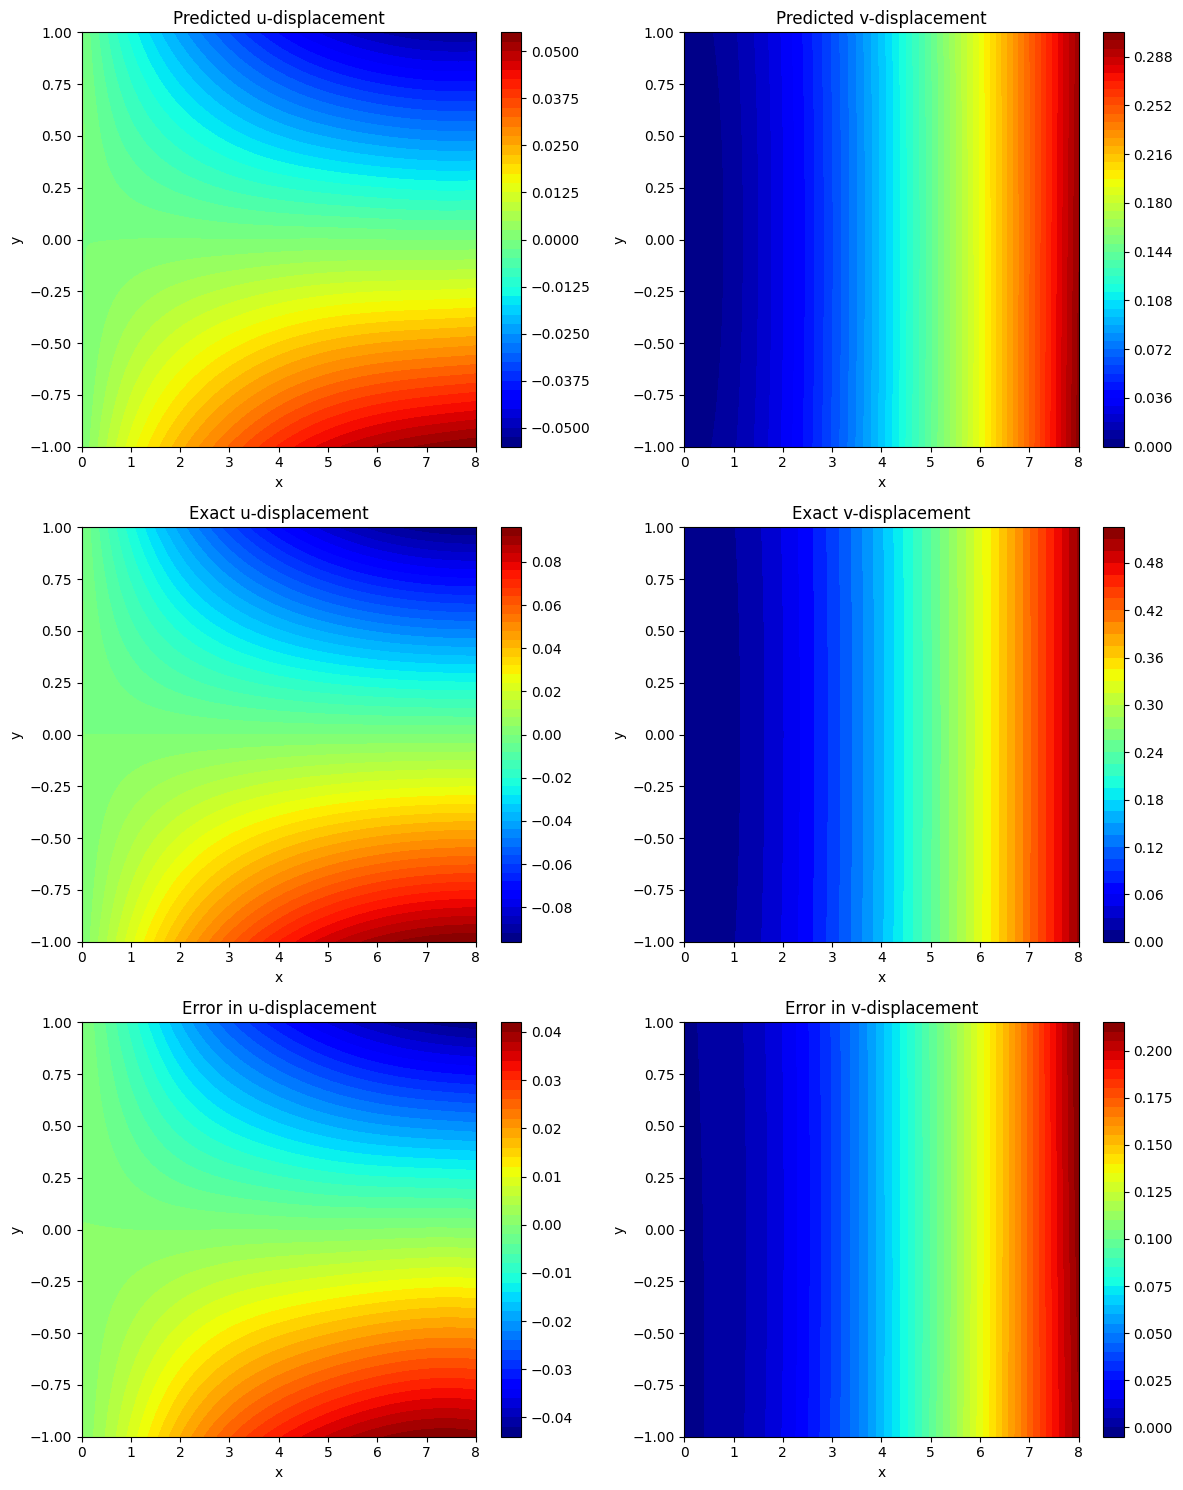

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set default tensor type and device
torch.set_default_dtype(torch.float64)

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check if MPS is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

# Material and geometric parameters
E = 1e3           # Young's modulus
nu = 0.25         # Poisson's ratio
P = -2.0          # Applied load
L = 8.0           # Length of the beam
W = 2.0           # Width of the beam
b = 1.0           # Depth of the beam
I = b * W**3 / 12.0   # Moment of inertia
lambda_ = E * nu / ((1 + nu)*(1 - 2*nu))  # Lamé's first parameter
mu = E / (2*(1 + nu))  # Lamé's second parameter (shear modulus)

# Generate interior collocation points (excluding x=0)
Nx, Ny = 80, 40  # Original grid size
x = np.linspace(0, L, Nx)[1:]  # Exclude x=0 point
y = np.linspace(-W/2, W/2, Ny)[1:-1]  # Exclude top and bottom boundaries
X, Y = np.meshgrid(x, y)
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Generate boundary points
# Right boundary (x = L)
y_right = np.linspace(-W/2, W/2, Ny)
x_right = L * np.ones_like(y_right)
X_right = np.hstack((x_right[:, None], y_right[:, None]))

# Top boundary (y = W/2)
x_top = np.linspace(0, L, Nx)[1:]  # Exclude x=0
y_top = (W/2) * np.ones_like(x_top)
X_top = np.hstack((x_top[:, None], y_top[:, None]))

# Bottom boundary (y = -W/2)
x_bottom = np.linspace(0, L, Nx)[1:]  # Exclude x=0
y_bottom = (-W/2) * np.ones_like(x_bottom)
X_bottom = np.hstack((x_bottom[:, None], y_bottom[:, None]))

# Combine all boundary points
X_boundary = np.vstack((X_right, X_top, X_bottom))

# Convert to torch tensors
x_collocation = torch.tensor(X_star[:, 0:1], requires_grad=True, device=device)
y_collocation = torch.tensor(X_star[:, 1:2], requires_grad=True, device=device)

x_boundary_tensor = torch.tensor(X_boundary[:, 0:1], requires_grad=True, device=device)
y_boundary_tensor = torch.tensor(X_boundary[:, 1:2], requires_grad=True, device=device)

# Plot collocation points
plt.figure(figsize=(8, 4))

# Interior points (blue)
plt.scatter(X_star[:, 0], X_star[:, 1], c='blue', s=2, alpha=0.6, label='Interior')

# Boundary points (red)
plt.scatter(X_boundary[:, 0], X_boundary[:, 1], c='red', s=4, label='Boundary')

plt.title('Collocation Points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hdim = 20
        self.layers = nn.Sequential(
            nn.Linear(2, hdim),
            Swish(),
            nn.Linear(hdim, hdim),
            Swish(),
            nn.Linear(hdim, hdim),
            Swish(),
            nn.Linear(hdim, hdim),
            Swish(),
            nn.Linear(hdim, 2)
        )

    def forward(self, x, y):
        inputs = torch.cat((x, y), dim=1)
        outputs = self.layers(inputs)
        return outputs[:, 0:1], outputs[:, 1:2]


# Initialize model and move to device
model = Net().to(device)

# Initialize weights properly
torch.manual_seed(42)
for m in model.layers:
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

def linear_distance(x, L):
    """Current simple linear distance function"""
    return x/L

def polynomial_distance(x, L, n=3):
    """Polynomial distance function
    n: polynomial degree (odd number)"""
    return (x/L)**n * (1 - (x/L))**(n-1) + x/L

# The correct strong form enforcement
def net_u(x, y):
    u_NN, _ = model(x, y)
    # Analytical solution at x=0
    g_u = (P * y) / (6 * E * I) * ((2 + nu) * (y**2 - W**2/4))
    # Distance function x/L
    weight = linear_distance(x, L)
    return g_u * (1-weight) + weight * u_NN

def net_v(x, y):
    _, v_NN = model(x, y)
    # Analytical solution at x=0
    g_v = -(P) / (6 * E * I) * (3 * nu * y**2 * L)
    # Distance function x/L
    weight = linear_distance(x, L)
    return g_v * (1-weight) + weight * v_NN

def strain(x, y):
    u = net_u(x, y)
    v = net_v(x, y)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                             create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                             create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),
                             create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v),
                             create_graph=True)[0]

    epsilon_xx = u_x
    epsilon_yy = v_y
    epsilon_xy = 0.5 * (u_y + v_x)

    return epsilon_xx, epsilon_yy, epsilon_xy

def stress(x, y):
    epsilon_xx, epsilon_yy, epsilon_xy = strain(x, y)

    sigma_xx = lambda_ * (epsilon_xx + epsilon_yy) + 2 * mu * epsilon_xx
    sigma_yy = lambda_ * (epsilon_xx + epsilon_yy) + 2 * mu * epsilon_yy
    sigma_xy = 2 * mu * epsilon_xy

    return sigma_xx, sigma_yy, sigma_xy

def traction_x(y):
    return torch.zeros_like(y)

def traction_y(y):
    return P * (y**2 - y * W) / (2 * I)

def potential_energy():
    # Get strains and stresses at collocation points
    epsilon_xx, epsilon_yy, epsilon_xy = strain(x_collocation, y_collocation)
    
    # Compute strain energy density
    # First term: λ(εxx + εyy)^2
    psi_1 = 0.5 * lambda_ * (epsilon_xx + epsilon_yy)**2
    
    # Second term: μ(εxx^2 + εyy^2 + 2εxy^2)
    psi_2 = mu * (epsilon_xx**2 + epsilon_yy**2 + 2 * epsilon_xy**2)
    
    # Total strain energy density
    strain_energy_density = psi_1 + psi_2
    
    # Alternative: Compute strain energy density using stress-strain product
    # Get stresses at collocation points
    # sigma_xx, sigma_yy, sigma_xy = stress(x_collocation, y_collocation)
    # strain_energy_density = 0.5 * (
    #     sigma_xx * epsilon_xx + 
    #     sigma_yy * epsilon_yy + 
    #     2 * sigma_xy * epsilon_xy
    # )
    
    # Numerical integration over domain
    dx = L / (Nx - 1)
    dy = W / (Ny - 1)
    element_area = dx * dy
    
    # Internal energy = ∫∫ Ψ dxdy
    internal_energy = strain_energy_density.sum() * element_area
    
    # External work from traction on right boundary
    # Get displacements on right boundary
    u_right = net_u(x_boundary_tensor[:Ny], y_boundary_tensor[:Ny])
    v_right = net_v(x_boundary_tensor[:Ny], y_boundary_tensor[:Ny])
    
    # Traction components on right boundary
    t_x_right = torch.zeros_like(y_boundary_tensor[:Ny])
    t_y_right = -P * (y_boundary_tensor[:Ny]**2 - y_boundary_tensor[:Ny] * W) / (2 * I)
    
    # External work = -∫ t·u dΓ
    external_work = -(t_x_right * u_right + t_y_right * v_right).sum() * (W/(Ny-1))
    
    # Total potential energy = Internal + External
    total_energy = internal_energy + external_work
    
    return total_energy

# Training loop
def closure():
    optimizer.zero_grad()
    energy = potential_energy()
    energy.backward()
    return energy

print("Initial energy:", potential_energy().item())

# First train with Adam
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 15000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    energy = potential_energy()
    energy.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Energy: {energy.item():.6f}')

# Then refine with L-BFGS
optimizer = optim.LBFGS(model.parameters(), 
                       max_iter=500,
                       max_eval=500, 
                       tolerance_grad=1e-7,
                       tolerance_change=1e-7,
                       history_size=50)

print('Starting L-BFGS optimization...')
optimizer.step(closure)
print("Final energy:", potential_energy().item())

# Testing the model
x_test = np.linspace(0, L, 2*Nx)
y_test = np.linspace(-W/2, W/2, 2*Ny)
X_test, Y_test = np.meshgrid(x_test, y_test)
X_star_test = np.hstack((X_test.flatten()[:, None], Y_test.flatten()[:, None]))

# Convert to torch tensors
x_test_tensor = torch.tensor(X_star_test[:, 0:1], requires_grad=True, device=device)
y_test_tensor = torch.tensor(X_star_test[:, 1:2], requires_grad=True, device=device)

# Predict displacements
u_pred = net_u(x_test_tensor, y_test_tensor).cpu().detach().numpy()
v_pred = net_v(x_test_tensor, y_test_tensor).cpu().detach().numpy()


def u_exact(x, y):
    term1 = (P * y) / (6 * E * I)
    term2 = (6 * L - 3 * x) * x + (2 + nu) * (y**2 - (W**2) / 4)
    return term1 * term2

def v_exact(x, y):
    term1 = -(P) / (6 * E * I)
    term2 = 3 * nu * y**2 * (L - x) + (3 * L - x) * x**2
    return term1 * term2

u_exact_val = u_exact(X_star_test[:, 0:1], X_star_test[:, 1:2])
v_exact_val = v_exact(X_star_test[:, 0:1], X_star_test[:, 1:2])
# Compute errors
error_u = np.linalg.norm(u_exact_val - u_pred, 2) / np.linalg.norm(u_exact_val, 2)
error_v = np.linalg.norm(v_exact_val - v_pred, 2) / np.linalg.norm(v_exact_val, 2)
print(f'Relative L2 error in u: {error_u:e}')
print(f'Relative L2 error in v: {error_v:e}')

# Reshape data for plotting
U_pred = u_pred.reshape(2*Ny, 2*Nx)
V_pred = v_pred.reshape(2*Ny, 2*Nx)
U_exact = u_exact_val.reshape(2*Ny, 2*Nx)
V_exact = v_exact_val.reshape(2*Ny, 2*Nx)
Error_U = (U_exact - U_pred)
Error_V = (V_exact - V_pred)

# Plotting the results
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

# Predicted displacements
cf = ax[0, 0].contourf(X_test, Y_test, U_pred, levels=50, cmap='jet')
fig.colorbar(cf, ax=ax[0, 0])
ax[0, 0].set_title('Predicted u-displacement')
ax[0, 0].set_xlabel('x')
ax[0, 0].set_ylabel('y')

cf = ax[0, 1].contourf(X_test, Y_test, V_pred, levels=50, cmap='jet')
fig.colorbar(cf, ax=ax[0, 1])
ax[0, 1].set_title('Predicted v-displacement')
ax[0, 1].set_xlabel('x')
ax[0, 1].set_ylabel('y')

# Exact displacements
cf = ax[1, 0].contourf(X_test, Y_test, U_exact, levels=50, cmap='jet')
fig.colorbar(cf, ax=ax[1, 0])
ax[1, 0].set_title('Exact u-displacement')
ax[1, 0].set_xlabel('x')
ax[1, 0].set_ylabel('y')

cf = ax[1, 1].contourf(X_test, Y_test, V_exact, levels=50, cmap='jet')
fig.colorbar(cf, ax=ax[1, 1])
ax[1, 1].set_title('Exact v-displacement')
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('y')

# Errors
cf = ax[2, 0].contourf(X_test, Y_test, Error_U, levels=50, cmap='jet')
fig.colorbar(cf, ax=ax[2, 0])
ax[2, 0].set_title('Error in u-displacement')
ax[2, 0].set_xlabel('x')
ax[2, 0].set_ylabel('y')

cf = ax[2, 1].contourf(X_test, Y_test, Error_V, levels=50, cmap='jet')
fig.colorbar(cf, ax=ax[2, 1])
ax[2, 1].set_title('Error in v-displacement')
ax[2, 1].set_xlabel('x')
ax[2, 1].set_ylabel('y')

plt.tight_layout()
plt.savefig('02-linear-elastic.png', dpi=300)
plt.show()